In [45]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch

In [38]:


def get_mi(prec,sm):
    shp = prec.shape
    mi = np.zeros(shp,dtype=np.float)

    for i in range(shp[0]):
        m = prec[i]
        if m < sm[0]:
            mi_index = 0
        elif m < sm[1]:
            mi_index = (m - sm[0])/(sm[1] - sm[0])
        elif m < sm[2]:
            mi_index = 1.
        elif m < sm[3]:
            mi_index = (m - sm[3])/(sm[2] - sm[3])
        else:
            mi_index = 0.
        mi[i] = mi_index

    return mi

def get_ti(td,tn,dv):
    shp = td.shape
    ti = np.zeros(shp,dtype=np.float)

    for i in range(shp[0]):
        hi_temp = td[i]
        low_temp = tn[i]
        dt = hi_temp - low_temp
        if dt > 0:
            iq = min( 1, 12 * max(0, hi_temp - dv[0]) ** 2 / dt / ((dv[1] - dv[0]) * 24))
        else:
            iq = np.nan
        ih = min( 1 - ( max(0, hi_temp - dv[2]) / (dv[3] - dv[2])) , 1)
        ti[i] = iq * ih
    return ti

def get_ei(path_to_rep,species,date):

  path_to_data = path_to_rep + 'analysis/'

  data_temp_max = pd.read_csv(path_to_data+'tmax.csv',encoding="UTF-8")
  data_temp_min = pd.read_csv(path_to_data+'tmin.csv',encoding="UTF-8")
  data_precp = pd.read_csv(path_to_data+'precp.csv',encoding="UTF-8")
  data_species = pd.read_csv(path_to_rep+'species.csv',encoding="UTF-8")

#  station_id = data_temp_max['id']
  temp_max = data_temp_max[['name',date]]
  temp_min = data_temp_min[['name',date]]
  precp = data_precp[['name',date]]

  ind = (data_species['scientific_name'] == species)
  sm, dv = np.zeros(4), np.zeros(4)
  for i in range(4):
    key = 'sm_' + '%1.1d' % i
    sm[i] =  data_species[key][ind]
    key = 'dv_' + '%1.1d' % i
    dv[i] =  data_species[key][ind]

  raw_data = temp_max.merge(temp_min,left_on='name',right_on='name')
  raw_data = raw_data.merge(precp,left_on='name',right_on='name')

  param = {}
  name = np.array(raw_data['name'])
  tmax = np.array(raw_data[date+'_x'])
  tmin = np.array(raw_data[date+'_y'])
  precp = np.array(raw_data[date])
  ind = (tmax>=-100) * (tmin>=-100) * (precp>=-100)

  name = name[ind]
  tmax = tmax[ind]
  tmin = tmin[ind]
  precp = precp[ind]

  ei = np.zeros(name.shape[0])

  ti = get_ti(tmax,tmin,dv)
  mi = get_mi(precp,sm)

  ei = ti * mi

#  for i in range(ei.shape[0]):
#    print ('%s %6.2f %6.2f %6.2f' %(name[i],ei[i],tmax[i],precp[i]))

  return name, ei

def run_ei(path_to_rep,species,date):
    name, ei = get_ei(path_to_rep,species,date)
    sta = pd.read_csv("../CWB_Stations_171226.csv")
    sta = sta[['id','long','lat']]
    eidt=pd.DataFrame(data={a:b for a,b in zip(name,ei)},index=['EI']).T
    eidt = eidt.merge(sta, left_index=True, right_on='id')
    return eidt



def main():

    date = '2017-12'
    path_to_rep = "../"
    species = 'solenopsis_invicta'

    #            str         str      
#    name, ei = get_ei(path_to_rep,species,date)
    eidt = run_ei(path_to_rep,species,date)
    return eidt


if __name__ == '__main__':

    eidt = main()


/Users/nghianc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater_equal


In [40]:
eidt.head()

,EI,id,long,lat
1,1.000000,466880,121.4420,24.9976
2,0.636364,466900,121.4489,25.1649
3,0.000000,466910,121.5297,25.1826
4,1.000000,466920,121.5149,25.0377
5,0.000000,466930,121.5445,25.1621


In [26]:
sta = pd.read_csv("../CWB_Stations_171226.csv")
sta = sta[['id','long','lat']]
eidt=pd.DataFrame(data={a:b for a,b in zip(name,ei)},index=['EI']).T

In [85]:
def plot_ei(df):
    df = df.dropna(axis = 0, how="any")
    lons = np.array(df.long)
    lats = np.array(df.lat)
    data = np.array(df.EI)
    grid_space = 0.1
    grid_lon = np.arange(lons.min()-0.05, lons.max()+0.1, grid_space) 
    grid_lat = np.arange(lats.min()-0.05, lats.max()+0.1, grid_space)
    OK = OrdinaryKriging(lons, lats, data, variogram_model='gaussian', verbose=True, enable_plotting=False,nlags=20)
    z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
    xintrp, yintrp = np.meshgrid(grid_lon, grid_lat)
    
    ind = (z1>1)
    z1[ind] = 1
    ind = (z1<0)
    z1[ind] = 0
    
    fig, ax = plt.subplots(figsize=(10,10))
    m = Basemap(llcrnrlon=119.5,llcrnrlat=21.5,
                urcrnrlon=122.5,urcrnrlat=26, projection='merc', 
                resolution='l',area_thresh=1000.,ax=ax)
    m.drawcoastlines() #draw coastlines on the map
    x,y=m(xintrp,yintrp)
    lo,la = m(lons,lats)
    cs = ax.contourf(x,y,z1,
                       cmap="rainbow",
                       levels = np.linspace(0,1,10))
    #cs = ax.scatter(lo,la,c=data,cmap="rainbow")
    ax.scatter(lo,la,c=data,cmap="rainbow",vmin=0,vmax=1,edgecolor="k")
    cbar=m.colorbar(cs,location='right') #plot the colorbar on the map
    parallels = np.arange(21.5,26.0,1)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=14, linewidth=0.0) #Draw the latitude labels on the map
    meridians = np.arange(119.5,123.5,1)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=14, linewidth=0.0)

    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])
    polys = [p.boundary for p in m.landpolygons]
    polys = [map_edges]+polys[:]
    codes = [
    [Path.MOVETO]+[Path.LINETO for p in p[1:]]
    for p in polys
    ]

    polys_lin = [v for p in polys for v in p]
    codes_lin = [c for cs in codes for c in cs]

    path = Path(polys_lin, codes_lin)
    patch = PathPatch(path,facecolor='white', lw=0)
    ax.add_patch(patch)
    plt.show()    
    return xintrp,yintrp,z1

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.15840664699
Full Sill: 0.158406649332
Range: 0.225992818234
Nugget: 2.34138683696e-09 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



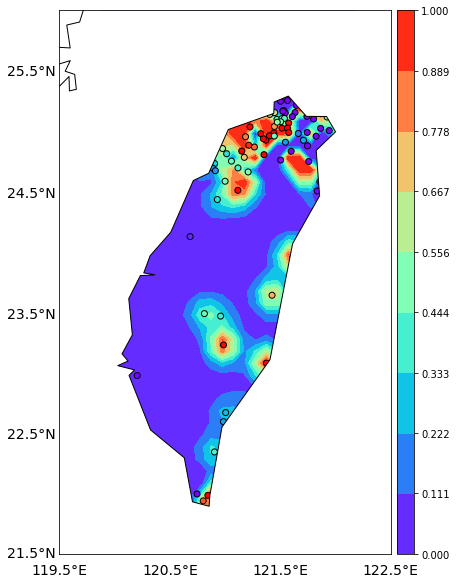

In [86]:
x,y,z1 = plot_ei(eidt)

In [68]:
for i in range

(44, 24)

In [83]:
ind = (z1>1)
z1[ind] = 1

In [84]:
z1

masked_array(data =
 [[0.04842390147239535 0.04842390147239527 0.04842390147165748 ...,
  0.04842342595354582 0.048423899673482027 0.048423901482567006]
 [0.04842390147239535 0.04842390147239527 0.048423901470470175 ...,
  0.048422478449260606 0.04842389611841342 0.04842390147129111]
 [0.04842390147239535 0.04842390147239527 0.04842390147140206 ...,
  0.0484226179063163 0.04842389664035171 0.048423901497300775]
 ..., 
 [0.04800526951198475 0.04800526951198475 0.04829771981970807 ...,
  0.04857017173097808 0.04871123529783597 0.048594031654336754]
 [0.0465784326388092 0.0465784326388092 0.04786765080431765 ...,
  0.04842487905612876 0.048425821799201664 0.04842503851385249]
 [0.04597176358562539 0.04597176358562539 0.047684792071284066 ...,
  0.04842390345600399 0.048423905363553676 0.04842390380102436]],
             mask =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ...,